# Optogenetic Model Evaluation

*(last run on an old version of Cleo...maybe v0.10.0 or thereabouts)*

In [12]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(["seaborn-v0_8-paper"])
matplotlib.rcParams["font.sans-serif"] = "Open Sans"
matplotlib.rcParams["svg.fonttype"] = "none"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Light Model

### 3D graphic
First we'll compare the model to figure 2A from Foutz et al. 2012.

| <img src="img/orig/foutz12_2a.jpg" alt="Foutz et al. 2012 Figure 2A" width="500"> |
| - |
| <img src="img/repl/foutz12_2a.svg" alt="replicated Foutz et al. 2012 Figure 2A" width="500"> |

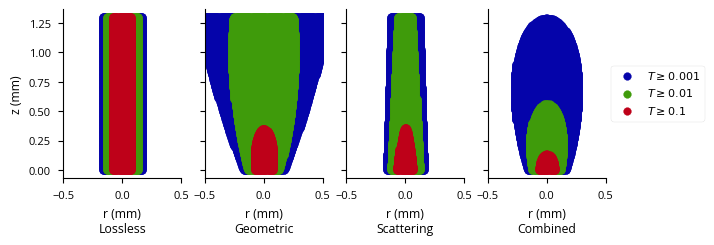

In [13]:
from matplotlib import colors
from brian2 import mm, np
import brian2.units.unitsafefunctions as usf

from cleo.opto import *
from cleo.light import *


fiber_model = fiber473nm()

x = np.linspace(-0.9, 0.9, 200)
y = np.linspace(-0.2, 1.3, 300)
x, y = np.meshgrid(x, y)
dir_uvec = np.array([[0], [1]])

coords = np.vstack([x.flatten(), y.flatten()]).T
coords = coords * mm
z = usf.dot(coords, dir_uvec)  # distance along cylinder axis
r = np.sqrt(np.sum((coords - usf.dot(z, dir_uvec.T)) ** 2, axis=1))
r = r.reshape((-1, 1))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(7, 3))
ax1.set_ylabel("z (mm)")


def plot_panel(ax, T, label):
    # filter out points with <0.001 transmittance to make plotting faster
    blue_T = 0.001
    idx_to_plot = T[:, 0] >= blue_T
    x_plot = x.flatten()[idx_to_plot]
    y_plot = y.flatten()[idx_to_plot]
    T = T[idx_to_plot, 0]

    def plot_interval(start, stop, color):
        idxs = (T >= start) & (T < stop)
        ax.scatter(
            x_plot[idxs],
            y_plot[idxs],
            c=color,
            marker="o",
            label=f"$T \geq {start}$",
            rasterized=True,
        )

    plot_interval(0.001, 0.01, "xkcd:royal blue")
    plot_interval(0.01, 0.1, "xkcd:grass green")
    plot_interval(0.1, 1, "xkcd:scarlet")
    ax.set_aspect("equal")
    ax.set_xlim((-0.5, 0.5))
    ax.set_xlabel(f"r (mm)\n{label}")


plot_panel(
    ax1,
    fiber_model._Foutz12_transmittance(r, z, spread=False, scatter=False),
    "Lossless",
)
plot_panel(ax2, fiber_model._Foutz12_transmittance(r, z, scatter=False), "Geometric")
plot_panel(ax3, fiber_model._Foutz12_transmittance(r, z, spread=False), "Scattering")
plot_panel(ax4, fiber_model._Foutz12_transmittance(r, z), "Combined")
ax4.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.savefig("img/repl/foutz12_2a.svg", bbox_inches="tight", facecolor="white", dpi=300)

Qualitatively it looks pretty close. The scattering plot is the most off, but that could be a result of differences in how the plots are generated. They are using 3D shells which could be sliced at an angle and I'm using point samples.

We need to save just the last subplot for the figure:

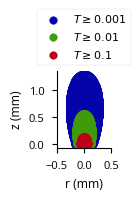

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(0.8, 1))
plot_panel(ax, fiber_model._Foutz12_transmittance(r, z), "")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1))
ax.set_ylabel("z (mm)")
sns.despine(ax=ax)
fig.savefig("img/fig/opto_trans_shape.png", bbox_inches="tight", dpi=400)

### Transmission-distance plot
Next we'll try to replicate figure 2B from Foutz et al. 2012. The x-axis represents distance from light to the cell body, ranging from 0 to 2 mm. Each line is for optic fibers of different radii.

| <img src="foutz12_2b.jpg" alt="Foutz et al. 2012 Figure 2B" width="500"/> |
| - |
| <img src="foutz12_2b_replicated.svg" alt="Foutz et al. 2012 Figure 2B" width="500"/> |

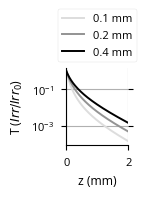

In [6]:
plt.figure(figsize=(0.8, 1))
z = np.linspace(0, 2, 200) * mm
g = False
fiber_model.R0 = 0.05 * mm
T1 = fiber_model._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
# fiber_model.light_model_params['R0'] = 0.2*mm
fiber_model.R0 = 0.2 * mm
T4 = fiber_model._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
# fiber_model.light_model_params['R0'] = 0.1*mm
fiber_model.R0 = 0.1 * mm
T2 = fiber_model._Foutz12_transmittance(np.zeros_like(z), z, gaussian=g)
plt.plot(z / mm, T1, c="#DDDDDD", label="0.1 mm")
plt.plot(z / mm, T2, c="#939393", label="0.2 mm")
plt.plot(z / mm, T4, c="k", label="0.4 mm")
plt.yscale("log")
plt.ylabel("T ($Irr/Irr_0$)")
plt.xlabel("z (mm)")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1))
plt.grid(True)
plt.tick_params(right=True, which="both")
plt.xlim(0, 2)
sns.despine()
plt.savefig("img/fig/fiber_model_trans_dist.svg", bbox_inches="tight")

## Opsin model
Now let's see that the opsin model is working as expected. This chart is the result of the ramp protocol for ChR2 from PyRhO (Evans et al., 2016):

| <img src="pyrho_ChR2_ramp.png" alt="PyRhO ChR2 ramp protocol" width="500"/> |
| - |
| <img src="img/fig/opto_ramp.svg" alt="replicated PyRhO ChR2 ramp protocol" width="500"/> |

In [6]:
import matplotlib.pyplot as plt
import brian2 as b2
import cleo
from cleo.coords import assign_coords_grid_rect_prism

b2.prefs.codegen.target = "numpy"

ng = b2.NeuronGroup(
    3,
    """
        v = -70*mV : volt
        Iopto : amp""",
)
assign_coords_grid_rect_prism(ng, (0, 0), (0, 0), (0, 0), shape=(3, 1, 1))
net = b2.Network(ng)
sim = cleo.CLSimulator(net)

chr2 = cleo.opto.chr2_4s()
sim.inject(chr2, ng)
fiber = cleo.light.Light(
    light_model=cleo.light.fiber473nm(), wavelength=473 * b2.nmeter
)
sim.inject(fiber, ng)

pulse_width = 250 * b2.ms

opto_syn = chr2.synapses[ng.name]
Ephoton = (
    6.63e-34
    * b2.meter**2
    * b2.kgram
    / b2.second
    * 2.998e8
    * b2.meter
    / b2.second
    / fiber.wavelength
)
# converting from photon flux to irradiance at point (Irr) to fiber tip irradiance (Irr0)
# phi [1e18, 1e17, 1e16] * Ephoton / T
fiber.source.run_regularly(
    """pulse = t < pulse_width
        Irr0_peak = 1e18/10**i /second/mm2 * Ephoton / T
        Irr0 = pulse * Irr0_peak * (t/pulse_width)
""",
    name="stim",
)

Omon = b2.StateMonitor(opto_syn, ["O1", "C1", "C2", "O2", "phi_pre"], record=True)
Iopto_mon = b2.StateMonitor(ng, ["Iopto"], record=True)
net.add(Omon, Iopto_mon)

sim.run(pulse_width + 50 * b2.ms)

### Plots
fig = plt.figure(figsize=(2.1, 1.5))
ax_size_factor = 3
ax1 = plt.subplot2grid(shape=(ax_size_factor, 1), loc=(0, 0), fig=fig)
l_phi = ax1.plot(Omon.t / b2.ms, Omon.phi.T * b2.mm2)
for line, c in zip(l_phi, ["k", "#939393", "#DDDDDD"]):
    line.set_color(c)
ax1.set(ylabel="$\phi$\n(ph./mm$^2$/s)", xticklabels=[])

ax2 = plt.subplot2grid(shape=(ax_size_factor, 1), loc=(1, 0), rowspan=4)
l_I = ax2.plot(Iopto_mon.t / b2.ms, -Iopto_mon.Iopto_.T / b2.namp)
for line, c in zip(l_I, ["k", "#939393", "#DDDDDD"]):
    line.set_color(c)
ax2.set(ylabel="$I_{opto}$\n(nA)", xlabel="Time (ms)")
# ax2.legend([str(x) for x in [18, 17, 16]])
# ax2.legend(['$\phi_{max}=$1e' + str(x) + ' (ph./mm$^2$/s)' for x in [18, 17, 16]])
# plt.tight_layout()
sns.despine()
plt.savefig("img/fig/opto_ramp.svg", bbox_inches="tight")

BrianObjectException: Error encountered with object named 'stim'.
Object was created here (most recent call only, full details in debug log):
  File '/tmp/ipykernel_28942/688994593.py', line 30, in <module>
    fiber.source.run_regularly('''pulse = t < pulse_width

An error occurred when preparing an object. (See above for original error message and traceback.)

In [21]:
fiber.source.equations

Irr0 : watt / (meter ** 2)


## Spatially dependent stimulation response

We will now check that neurons fire more in response to light when more propagated light reaches them. The firing rates should correlate to the light transmission profile we've already seen.

In [101]:
def make_ngs(n):
    neuron_params = {
        "a": 0.0 * nsiemens,
        "b": 60 * pamp,
        "E_L": -70 * mV,
        "tau_m": 20 * ms,
        "R": 500 * Mohm,
        "theta": -50 * mV,
        "v_reset": -55 * mV,
        "Delta_T": 2 * mV,
    }
    ng_lif = NeuronGroup(
        n,
        """dv/dt = (-(v - E_L) + R*Iopto) / tau_m : volt
        Iopto: amp
        """,
        threshold="v>=theta",
        reset="v=E_L",
        refractory=2 * ms,
        namespace=neuron_params,
        name="LIF",
    )
    ng_eif = NeuronGroup(
        n,
        """dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + R*Iopto) / tau_m : volt
        Iopto : amp""",
        threshold="v>=30*mV",
        reset="v=v_reset",
        namespace=neuron_params,
        name="EIF",
    )
    ngs = [ng_lif, ng_eif]
    for ng in ngs:
        ng.v = neuron_params["E_L"]
    return ngs

In [74]:
from brian2 import *
from cleo.coords import assign_coords_grid_rect_prism

prefs.codegen.target = "numpy"

_, ng = make_ngs(150)

pop_mon = SpikeMonitor(ng, record=True)

assign_coords_grid_rect_prism(
    ng,
    xlim=(-0.25, 0.25),
    ylim=(-0.25, 0.25),
    zlim=(0.2, 1.2),
    unit=mm,
    shape=(5, 5, 6),
)

from cleo.base import CLSimulator

net = Network(pop_mon, ng)
sim = CLSimulator(net)

from cleo.opto import *

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=FourStateModel(ChR2_4S),
    light_model_params=default_blue,
    location=(0, 0, 0) * mm,
)
sim.inject(opto, ng)
opto.update(10)

sim.run(1000 * ms)

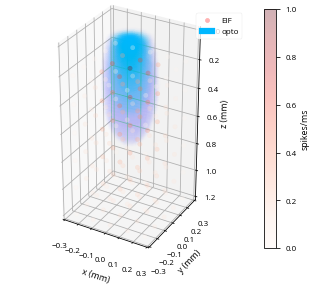

In [75]:
counts = np.bincount(pop_mon.i)
counts = np.hstack((counts, np.zeros(150 - len(counts))))

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from cleo.viz import _plot

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
neuron_artists, _ = _plot(
    ax, [ng], (-0.3, 0.3), (-0.3, 0.3), (0, 1.2), colors=["red"], devices=[opto]
)

c = counts / 1000
color = cm.get_cmap("Reds")(c)
neuron_artists[0].set_cmap("Reds")
neuron_artists[0].set_color(color)
plt.colorbar(neuron_artists[0], label="spikes/ms")
fig.savefig("opto_firing_rates.png", transparent=True)